<a href="https://colab.research.google.com/github/shreyasmiraj/dynamical_system_sparse_EI_network/blob/main/E_I_network_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Misc

## ssh

In [ ]:
!pip install CFsshTunnel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from getpass import getpass
from CFsshTunnel.CFsshTunnel import CFsshTunnel
from CFsshTunnel.utils.utils import keep_alive
from CFsshTunnel.code_server.code_server import launch_codeserver

_, hostname, user = CFsshTunnel()
# launch_codeserver(user=user, hostname=hostname)

Checking for openssh-server
openssh-server already installed
Checking for cloudflared
cloudflared already installed
authorized ssh-rsa pub auth keys sep by newline:··········


+---------------------------------------------------+
| open_ssh_cloudflare tunnel route is now alive at: |
| bright-turning-amended-bennett.trycloudflare.com  |
+---------------------------------------------------+


Update ~/.ssh/config on client as below:

#Client ~/.ssh/config
#----------------------------------------------------
Host bright-turning-amended-bennett.trycloudflare.com
	Hostname %h
	User root
	Port 59241
	LogLevel ERROR
	UserKnownHostsFile /dev/null
	ProxyCommand cloudflared access ssh --hostname %h
#----------------------------------------------------
Note: Windows client users on PS/cmd, provide full path to cloudflared.exe in ProxyCommand
        Also applies to linux users if PATH to cloudflared isn't added to $PATH
        Ex: Instead of 
            `ProxyCommand cloudflared access ssh --

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reference Paper 
[Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons](https://pubmed.ncbi.nlm.nih.gov/10809012/)

#Import packages

In [1]:
import os
import math
import time
import scipy
import torch
import pickle
import warnings
import numpy as np
import numba as nb
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba.experimental import jitclass

#Helper Functions

In [2]:
def get_plot_grid(data_len, subplot_width=5, subplot_height=5):
  """Generates matplotlib figure with subplots in a square grid based on data len

  Parameters:
  -----------
    data_len : int
      length or number of subplots required
    subplot_width : float
      width of each subplot in inches
    subplot_height : float
      height of each subplot in inches
  
  Returns:
  --------
    fig, axes
  """
  subplot_width, subplot_height = (4,4)
  plot_grid = math.sqrt(data_len)
  if data_len == 3:
    n_rows = math.ceil(plot_grid)
  else:
    n_rows = math.floor(plot_grid)
  n_columns = math.ceil(plot_grid)
  plt.rcParams.update({'figure.autolayout': True})
  fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(subplot_width*n_columns, subplot_height*n_rows))
  if not isinstance(axs, np.ndarray):
    axs = np.array(axs)
  axs = axs.ravel()
  if data_len != n_rows*n_columns:
    for i in range(data_len,n_rows*n_columns):
      axs[i].set_axis_off()
  return fig, axs



def vprint(message, verbose=False):
  """ Conditional print
  
  Parameters:
  -----------
    
    message : str
      message to print
    verbose : bool
      condition for print

  """
  if verbose:
    print(message)



def timeit(start_time=None):
  """Function to time codeblocks
  
  Parameters:
  -----------

    start_time : float | None
      None to initilize start_time or start_time in float from a previously returned timeit
  
  Returns:
  --------

    float
    time of initilization if start_time is None or difference between start time and subsequent call to timeit in seconds.
  """
  if start_time == None:
    return time.time()
  else:
    end_time = time.time()
    return end_time - start_time



def save_pickle(file_path, var):
  """
    Saves python object to specified file path using pickle
    Inputs:
      file_path(str):path to file to store the object into
      var(object like):any python object
  """
  with open(file_path,"wb") as f:
    pickle.dump(var, f, pickle.HIGHEST_PROTOCOL)



def load_pickle(file_path):
  """
    Loads python object from specified file path using pickle
    Inputs:
      file_path(str):path to file to load the object from
  """
  with open(file_path,"rb") as f:
    return pickle.load(f)


# ffmpeg -framerate 60 -pattern_type glob -i '*.png' -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -c:v libx264 -pix_fmt yuv420p cartoon_network.mp4

#Euler method

##Single Neuron

In [8]:
class SingleNeuron:
  """
    Create a single neuron instance with the init parameters and evolve it for set duration
  """
  def __init__(self, v_init, v_rest, v_threshold, v_reset, v_change, g, R, I,
               t, dt, t_refractory, tau, 
               poisson_rate_excitatory, poisson_rate_inhibitory):
    """
    Parameters:
    -----------
      v_init : float
        initial membrane potential of the neuron in mV
      v_rest : float
        resting membrane potential in mV
      v_threshold : float
        threshold membrane potential required to fire an action potential in mV
      v_reset : float
        value of membrane potential in mV
      v_change : float
        change in membrane potential caused by input spike in mV
      g : float
        scaling factor for change in membrane potential caused by an inhibitory input spike
      R : float
        resistance of the membrane in ohm
      I : float
        DC constant input current in mA
      t : float
        duration of time in ms to run the simulation till
      dt : float
        euler step size in ms
      t_refractory : float
        refractory duration in ms
      tau : float
        time in ms that is required for change in voltage to take place
      poisson_rate_excitatory : float
        rate of input neurons that are excitatory in mHz
      poisson_rate_inhibitory : float
        rate of input neurons that are inhibitory in mHz

    Returns:
    --------
      SingleNeuron class instance
    """
    self.v_init = v_init
    self.v_rest = v_rest
    self.v_threshold = v_threshold
    self.v_reset = v_reset
    self.v_change = v_change
    self.g = g
    self.tau = tau
    self.R = R
    self.I = I
    self.t = t
    self.dt = dt
    self.t_refractory = t_refractory
    self.poisson_rate_excitatory = poisson_rate_excitatory
    self.poisson_rate_inhibitory = poisson_rate_inhibitory

    self.t_span = np.linspace(0, self.t, int(self.t/self.dt))
    self.v = np.zeros(self.t_span.shape[0])
    self.v[0] = self.v_init
    self.dv = np.zeros(self.t_span.shape[0])
    self.spike_data = []


  def evolve(self, return_state=False, tqdm_progress=True):
    """ Evolves single neuron through euler method
        
    Parameters:
    -----------
      return_state : bool
        set to true in order to return the computed parameters as mentioned in the Returns section.
      tqdm_progress : bool
        set to display progress bar

    Returns:
    --------
      if return_state is set to True
      v : numpy.array, dv : numpy.array, t_span : numpy.array, spike_data : numpy.array

    """
    
    #increase the number of poisson input neurons if requested freq is higher than maximum possible for t_span
    n_poisson_excitatory = math.ceil(self.poisson_rate_excitatory / (len(self.t_span) / (self.t * 1e-3)))
    n_poisson_inhibitory = math.ceil(self.poisson_rate_inhibitory / (len(self.t_span) / (self.t * 1e-3)))

    poisson_excitatory_process = np.sum(np.random.rand(len(self.t_span), n_poisson_excitatory) 
                                        < (self.poisson_rate_excitatory/max(1, n_poisson_excitatory)) * 1e-3 * self.dt,
                                        axis=1, dtype=np.float32)
    poisson_inhibitory_process = np.sum(np.random.rand(len(self.t_span), n_poisson_inhibitory) 
                                        < (self.poisson_rate_inhibitory/max(1, n_poisson_inhibitory)) * 1e-3 * self.dt,
                                        axis=1, dtype=np.float32)

    t_last = self.t_span[0]
    t_ref_timer = -1
    active_state = 1 #1 for active, 0 for refractory
    if tqdm_progress:
      iterable = tqdm(self.t_span[1:])
    else:
      iterable = self.t_span[1:]
    for i,t in enumerate(iterable):
      dT = t - t_last
      v_curr = self.v[i]
      #reset timer to -1 if timer is greater than or equal to t_ref
      if t_ref_timer >= self.t_refractory or t_ref_timer < 0:
        t_ref_timer = -1
        active_state = 1
      #increament t_ref_timer by dT if its in refractory state
      elif t_ref_timer < self.t_refractory and t_ref_timer >= 0:
        t_ref_timer += dT
      #if neuron is not in refractory state check if its firing
      if t_ref_timer == -1:
        if self.v[i] >= self.v_threshold:
          v_curr = self.v_reset
          t_ref_timer = 0
          active_state = 0
          self.spike_data.append(t)
      #input
      net_excitatory = self.v_change * (poisson_excitatory_process[i])
      net_inhibitory = self.g * -self.v_change * (poisson_inhibitory_process[i])
      v_imp = net_excitatory + net_inhibitory

      #not active dynamics is only for visualisation purposes
      dv_t = active_state * ((-1*(v_curr - self.v_rest) + (self.R*self.I))/self.tau) + np.logical_not(active_state) * (-v_curr + self.v_rest) * 0.001
      self.dv[i+1] = dv_t
      self.v[i+1] = v_curr + self.dv[i+1]*dT + active_state * v_imp
      t_last = t
    self.spike_data = np.array(self.spike_data, dtype=object)
    if return_state:
      return self.v, self.dv, self.t_span, self.spike_data


  def reset(self):
    """Reset neuron output parameters, run this after setting all neuron init parameters to desired value
    """
    self.t_span = np.linspace(0, self.t, int(self.t/self.dt))
    self.v = np.zeros(self.t_span.shape[0])
    self.v[0] = self.v_init
    self.dv = np.zeros(self.t_span.shape[0])
    self.spike_data = []

##Neural Network

In [7]:
#jit on cuda not improving runtime; probably falling back to python object mode execution?
@nb.jit(target_backend='cuda', nopython=True)
def synaptic_input_compute(scaled_connectivity_matrix, input_active_neurons):
  """computes total synaptic input per neuon
  Parameters:
  -----------

    scaled_connectivity_matrix : numpy.ndarray
      ndarray of shape n_totalxn_total given by connectivity_matrix*scaling factor*neuron_type*v_change
    input_active_neurons : numpy.array
      numpy array of shape n_total indicating neurons that can impart change in potential on its connections
  
  Returns:
  --------
    numpy:array
      sum of all the synaptic inputs for each neuron in the network
  """
  return scaled_connectivity_matrix * input_active_neurons
 

# spec = [('v_init', nb.float64[:]),
#                  ('v_rest',nb.float64),
#                  ('v_threshold', nb.float64),
#                  ('v_reset', nb.float64),
#                  ('v_change', nb.float64),
#                  ('g', nb.float64),
#                  ('tau', nb.float64),
#                  ('R', nb.float64),
#                  ('I', nb.float64),
#                  ('t', nb.float64),
#                  ('dt', nb.float64),
#                  ('t_refractory', nb.float64),
#                  ('t_synaptic', nb.float64),
#                  ('poisson_rate_excitatory', nb.float64),
#                  ('poisson_rate_inhibitory', nb.float64),
#                  ('n_total', nb.int64),
#                  ('p_excitatory', nb.float64),
#                  ('p_connectivity', nb.float64)]
# @jitclass(spec) #experimental
class NeuralNetwork:
  """Create network instance with init parameters and evolve the network through euler method
  """
  def __init__(self, v_init, v_rest, v_threshold, v_reset, v_change, g, tau, R, I,
               t, dt, t_refractory, t_synaptic,
               poisson_rate_excitatory, poisson_rate_inhibitory,
               n_total, p_excitatory, p_connectivity):
    """
    Parameters:
    -----------
      v_init : numpy.array
        numpy array of initial membrane potential values of size equal to n_total
      v_rest : float
        resting membrane potential in mV
      v_threshold : float
        threshold membrane potential required to fire an action potential
      v_reset : float
        value of membrane potential 
      v_change : float
        change in membrane potential caused by input spike in mV
      g : float
        scaling factor for change in membrane potential caused by an inhibitory input spike
      tau : float
        time in ms that is required for change in voltage to take place
      R : float
        resistance of the membrane in ohm
      I : float
        DC constant input current in mA
      t : float
        duration of time in ms to run the simulation till
      dt : float
        euler step size in ms
      t_refractory : float
        refractory duration in ms
      t_synaptic : float
        delay in synaptic input in ms
      poisson_rate_excitatory : float
        rate of poisson spike train that are excitatory in mHz
      poisson_rate_inhibitory : float
        rate of poisson spike train that are inhibitory in mHz
      n_total : int
        total number of neurons in the network
      p_excitatory : float
        probability of neurons in the network that are excitatory
      p_connectivity : float
        probability of connectivity between neurons in the network
    """
    self.v_init = v_init
    self.v_rest = v_rest
    self.v_threshold = v_threshold
    self.v_reset = v_reset
    self.v_change = v_change
    self.g = g
    self.tau = tau
    self.R = R
    self.I = I
    self.t = t
    self.dt = dt
    self.t_refractory = t_refractory
    self.t_synaptic = t_synaptic
    self.poisson_rate_excitatory = poisson_rate_excitatory
    self.poisson_rate_inhibitory = poisson_rate_inhibitory
    self.n_total = n_total
    self.p_excitatory = p_excitatory
    self.p_connectivity = p_connectivity

    self.t_span = np.linspace(0, self.t, int(self.t/self.dt), dtype=np.float32)
    self.v = np.empty((len(self.t_span),self.n_total), dtype=np.float32)
    self.dv = np.empty((len(self.t_span), self.n_total), dtype=np.float32)
    self.v[0][:] = self.v_init
    self.dv[0][:] = np.zeros(self.n_total, dtype=np.float32)
    self.connectivity_matrix = np.random.choice([0,1], size=(self.n_total, self.n_total), p=[1-self.p_connectivity, self.p_connectivity]).astype(np.bool8)
    self.neuron_type = np.random.choice([-1,1], size=self.n_total, p=[1-self.p_excitatory, self.p_excitatory]).astype(np.int8)
    self.spike_data = []
    for i in range(self.n_total):
      self.spike_data.append([])


  def evolve(self, return_state=False, verbose=False, tqdm_progress=True):
    """ Evolves network of neurons through euler method
    
    Parameters:
    -----------
      return_state : bool
        set to true in order to return the computed parameters as mentioned in the Returns section.
      verbose : bool
        set to verbose to print progress through code section
      tqdm_progress : bool
        set to display progress bar
    
    Returns:
    --------
    if return_state is set to True
      v : numpy.ndarray, dv : numpy.ndarray, t_span : numpy.array, connectivity_matrix : numpy.ndarray, neuron_type : numpy.arary

    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    scaling_factor = np.ones(self.n_total, dtype=np.float32)
    scaling_factor[np.where(self.neuron_type==-1)] *= self.g            #scale only inhibitory neuron inputs by a factor of g
    scaled_v_change = self.neuron_type * self.v_change * scaling_factor
    
    scaled_connectivity = (self.connectivity_matrix * scaled_v_change).astype(np.float32)
    scaled_connectivity_torch = torch.from_numpy(scaled_connectivity).to(torch.float32).to(device)

    
    #increase number of poisson input train if required frequency is greater than t_span length
    n_poisson_excitatory = math.ceil(self.poisson_rate_excitatory / (len(self.t_span) / (self.t * 1e-3)))
    n_poisson_inhibitory = math.ceil(self.poisson_rate_inhibitory / (len(self.t_span) / (self.t * 1e-3)))

    poisson_excitatory_process = np.sum(np.random.rand(len(self.t_span), self.n_total, n_poisson_excitatory)
                                        < (self.poisson_rate_excitatory / max(1, n_poisson_excitatory)) * 1e-3 * self.dt,
                                        axis=2, dtype=np.float32)
    poisson_inhibitory_process = np.sum(np.random.rand(len(self.t_span), self.n_total, n_poisson_inhibitory) 
                                        < (self.poisson_rate_inhibitory / max(1, n_poisson_inhibitory)) * 1e-3 * self.dt,
                                        axis=2, dtype=np.float32)
    

    t_ref_timer = np.full(self.n_total, -1, dtype=np.float32)   #initialize all timers to -1
    active_state = np.ones(self.n_total, dtype=np.bool8)        #initialize all neurons to active state        bool
    transmit_state = np.zeros(self.n_total, dtype=np.bool8)     #initialize all synaptic transmit state to 0   bool
    
    t_last = self.t_span[0]
    if tqdm_progress:
      iterable = tqdm(self.t_span[1:])
    else:
      iterable = self.t_span[1:]
    for i,t in enumerate(iterable):
      dT = t - t_last
      v_curr = self.v[i]

      #reset timer to -1 if timer is greater than or equal to t_ref
      non_refractory_neurons = np.where(np.logical_or(t_ref_timer >= self.t_refractory, t_ref_timer <0) == True)
      if len(non_refractory_neurons):
        t_ref_timer[non_refractory_neurons] = -1
        active_state[non_refractory_neurons] = 1

      #increament t_ref timer if initialized
      refractory_neurons = np.where(np.logical_and(t_ref_timer < self.t_refractory , t_ref_timer >= 0) == True)
      if len(refractory_neurons):
        t_ref_timer[refractory_neurons] += dT

      #check for threshold potential for active neurons and update state trackers and timers
      firing_neurons = np.where(np.logical_and(active_state == 1, v_curr >= self.v_threshold) == True)
      if len(firing_neurons):
        v_curr[firing_neurons] = self.v_reset
        t_ref_timer[firing_neurons] = 0
        active_state[firing_neurons] = 0
        transmit_state[firing_neurons] = 0
        for neuron_idx in firing_neurons[0]:
          self.spike_data[neuron_idx].append(t)

      #check for neurons that have fired and timer is > t_synaptic delay time and update state trackers
      input_active_neurons = np.logical_and(t_ref_timer >= self.t_synaptic, np.logical_not(transmit_state))
      input_active_neurons_torch = torch.from_numpy(input_active_neurons).to(torch.float32).to(device)
      input_active_index = np.where(input_active_neurons == True)
      transmit_state[input_active_index] = 1

      #compute all synaptic updates onto the neurons
      poisson_excitatory_input = self.v_change * poisson_excitatory_process[i]
      poisson_inhibitory_input = self.g * -self.v_change * poisson_inhibitory_process[i]
      # start = timeit()
      network_input = torch.sum(scaled_connectivity_torch * input_active_neurons_torch, dim=1, dtype=torch.float32).detach().cpu().numpy()
      # network_input = np.sum(synaptic_input_compute(scaled_connectivity, input_active_neurons), axis=1).reshape(-1)
      # print(timeit(start))
      v_imp = network_input + poisson_excitatory_input + poisson_inhibitory_input

      dv_t = (-1*(v_curr - self.v_rest) + (self.R*self.I))/self.tau
      v_t = v_curr + active_state * (dv_t*dT + v_imp)
      self.dv[i+1][:] = dv_t.reshape(-1)
      self.v[i+1][:] = v_t.reshape(-1)
      t_last = t

    del poisson_excitatory_process
    del poisson_inhibitory_process
    self.spike_data = np.array(self.spike_data, dtype=object)

    if return_state:
      return self.v, self.dv, self.t_span, self.connectivity_matrix, self.neuron_type, self.spike_data


  def reset(self, reset_connectivity=False):
    """Reset network output parameters, run this after setting all network init parameters to desired value
    """
    self.t_span = np.linspace(0, self.t, int(self.t/self.dt), dtype=np.float32)
    self.v = np.zeros((len(self.t_span), self.n_total), dtype=np.float32)
    self.dv = np.zeros((len(self.t_span), self.n_total), dtype=np.float32)
    self.v[0][:] = self.v_init
    self.dv[0][:] = np.zeros(self.n_total, dtype=np.float32)
    self.spike_data = []
    for i in range(self.n_total):
      self.spike_data.append([])
    if reset_connectivity:
      self.connectivity_matrix = np.random.choice([0,1], size=(self.n_total, self.n_total), p=[1-self.p_connectivity, self.p_connectivity]).astype(np.bool8)
      self.neuron_type = np.random.choice([-1,1], size=self.n_total, p=[1-self.p_excitatory, self.p_excitatory]).astype(np.int8)

###A. Phase portrait of the system for a steady current I and the time course of the membrane potential starting from rest.

In [9]:
neuron = SingleNeuron(v_init=-70,       #mV
                      v_rest=-70,       #mV
                      v_threshold=-50,  #mV
                      v_reset=-65,      #mV
                      v_change=0.2,     #mV
                      g=4,
                      R=10e6,           #ohm
                      I=2e-6,           #mA
                      t=1000,           #ms
                      dt=1e-2,          #ms
                      t_refractory=2,   #ms
                      tau=8,            #ms
                      poisson_rate_excitatory=0,  #mHz
                      poisson_rate_inhibitory=0)  #mHz
neuron.reset()

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

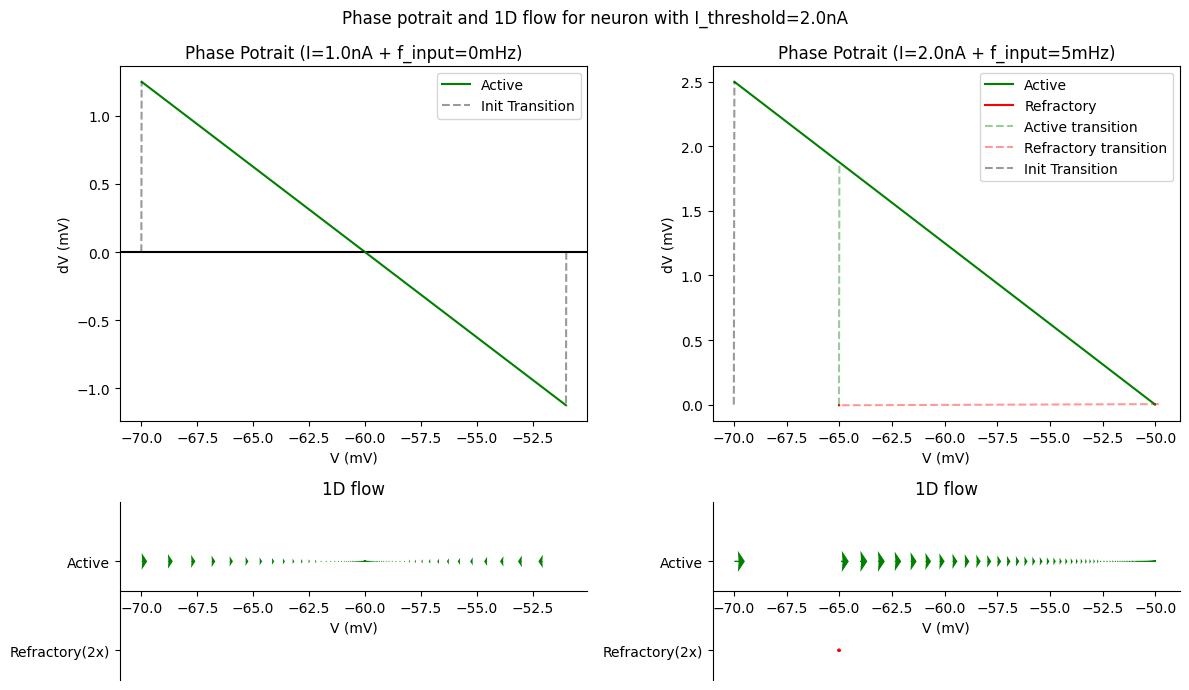

In [11]:
I_range = [1e-6, 2e-6]
poisson_rate_range = [0, 5]

fig, axes  = plt.subplots(nrows=2, ncols=len(I_range), gridspec_kw={'height_ratios': [4, 2]})
fig.set_tight_layout(True)
fig.set_figheight(7)
fig.set_figwidth(6*len(I_range))

for i,(I, poisson_rate_excitatory) in enumerate(zip(I_range, poisson_rate_range)):
  neuron.I = I
  neuron.v_init = -70 #mV
  neuron.poisson_rate_excitatory = poisson_rate_excitatory

  neuron.reset()
  neuron.evolve()

  #Plotting phase potrait and flow diagram
  init_transition_v = neuron.v[0:2]
  init_transition_dv = neuron.dv[0:2]
  
  firing = len(neuron.spike_data) > 0
  if firing:
    v = neuron.v
    dv = neuron.dv
    
    refractory_start = np.where(np.abs(np.diff(neuron.v)) >= neuron.v_threshold - neuron.v_reset - 1)[0]
    refractory_end = np.where(np.abs(np.diff(neuron.dv[1:])) >= ((neuron.R*neuron.I) - (neuron.v_reset+1 - neuron.v_rest))/neuron.tau)[0]+1
    refractory_transition_v = np.array([np.nanmean(neuron.v[refractory_start]), np.nanmean(neuron.v[refractory_start+1])])
    refractory_transition_dv = np.array([np.nanmean(neuron.dv[refractory_start]), np.nanmean(neuron.dv[refractory_start+1])])
    active_transition_v = np.array([np.nanmean(neuron.v[refractory_end]), np.nanmean(neuron.v[refractory_end+1])])
    active_transition_dv = np.array([np.nanmean(neuron.dv[refractory_end]), np.nanmean(neuron.dv[refractory_end+1])])
    nan_insert_loc = np.concatenate([refractory_start+1, refractory_end+1], axis=0)
    v = np.insert(v, nan_insert_loc, np.nan)
    dv = np.insert(dv, nan_insert_loc, np.nan)
    refractory_loc = np.where(np.diff(v) < 0)[0]
    active_loc = np.where(np.diff(v) >= 0)[0][1:] #skip init
    
    #1D flow
    active_sort = np.argsort(v[active_loc])
    v_active = v[active_loc][active_sort]
    dv_active = dv[active_loc][active_sort]
    x_active = v_active[slice(None, None, 250)]
    dx_active = dv_active[slice(None, None, 250)]
    y_active = np.full(len(x_active), 1)
    dy_active = np.zeros(len(x_active))

    refractory_sort = np.argsort(v[refractory_loc])
    v_refractory = v[refractory_loc][refractory_sort]
    dv_refractory = dv[refractory_loc][refractory_sort]
    x_refractory = v_refractory[slice(None, None, 200)]
    dx_refractory = dv_refractory[slice(None, None, 200)]
    y_refractory = np.full(len(x_refractory), -2)
    dy_refractory = np.zeros(len(x_refractory))

    axes[0][i].plot(v[active_loc], dv[active_loc], color='g')
    axes[0][i].plot(v[refractory_loc], dv[refractory_loc], color='r')
    axes[0][i].plot(active_transition_v, active_transition_dv, linestyle='--', color='g',alpha=0.4)
    axes[0][i].plot(refractory_transition_v, refractory_transition_dv, linestyle='--', color='r',alpha=0.4)
    axes[0][i].plot(init_transition_v, init_transition_dv, linestyle='--', color='k',alpha=0.4)
    axes[0][i].legend(['Active','Refractory','Active transition','Refractory transition', 'Init Transition'])
    axes[1][i].quiver(x_active, y_active, dx_active, dy_active, color='g',scale=5, scale_units='x', headwidth=15)
    axes[1][i].quiver(x_refractory, y_refractory, dx_refractory, dy_refractory, color='r', scale=2.5, scale_units='x', headwidth=15)

  if not firing:
    v = neuron.v[1:]
    dv = neuron.dv[1:]
    active_sort = np.argsort(v)
    v_active = v[active_sort]
    dv_active = dv[active_sort]
    x_active = v_active[slice(None, None, 100)]
    dx_active = dv_active[slice(None, None, 100)]
    y_active = np.full(len(x_active), 1)
    dy_active = np.zeros(len(x_active))

    axes[0][i].plot(v, dv, color='g')
    axes[0][i].plot(init_transition_v, init_transition_dv, linestyle='--', color='k',alpha=0.4)
    axes[0][i].legend(['Active','Init Transition'])
    axes[0][i].axhline(y=0, linestyle='-', color='k')
    axes[1][i].quiver(x_active, y_active, dx_active, dy_active, color='g',scale=5, scale_units='x', headwidth=15)

    #add v_init just lower than threshold when neuron doesn't spike / I < I_threshold and no poisson input
    if max(v) < neuron.v_threshold and (neuron.poisson_rate_excitatory == 0):
      neuron.v_init = neuron.v_threshold - 1 #mV
      neuron.reset()
      neuron.evolve()
      init_transition_v_ad = neuron.v[0:2]
      init_transition_dv_ad = neuron.dv[0:2]
      v_ad = neuron.v[1:]
      dv_ad = neuron.dv[1:]
      active_ad_sort = np.argsort(v_ad)
      v_active_ad = v_ad[active_ad_sort]
      dv_active_ad = dv_ad[active_ad_sort]
      x_active_ad = v_active_ad[slice(None, None, 100)]
      dx_active_ad = dv_active_ad[slice(None, None, 100)]
      y_active_ad = np.full(len(x_active_ad), 1)
      dy_active_ad = np.zeros(len(x_active_ad))
      axes[0][i].plot(v_ad, dv_ad, color='g')
      axes[0][i].plot(init_transition_v_ad, init_transition_dv_ad, linestyle='--', color='k',alpha=0.4)
      axes[1][i].quiver(x_active_ad, y_active_ad, dx_active_ad, dy_active_ad, color='g',scale=5, scale_units='x', headwidth=15)

  axes[0][i].set_xlabel('V (mV)')
  axes[0][i].set_ylabel('dV (mV)')
  axes[0][i].set_title('Phase Potrait (I='+str(neuron.I*1e6)+'nA + f_input='+str(neuron.poisson_rate_excitatory)+'mHz)')

  axes[1][i].spines['bottom'].set_position('center')
  axes[1][i].spines['right'].set_color('none')
  axes[1][i].spines['top'].set_color('none')
  axes[1][i].set_yticks(ticks=[-2,1],labels=['Refractory(2x)','Active'])
  axes[1][i].set_xlabel('V (mV)')
  axes[1][i].set_xlim(axes[0][i].get_xlim())
  axes[1][i].set_ylim(-3,3)
  axes[1][i].set_title('1D flow')

fig.suptitle('Phase potrait and 1D flow for neuron with I_threshold='+str(((neuron.v_threshold - neuron.v_rest)/neuron.R)*1e6)+'nA')
fig.show()

  0%|          | 0/99999 [00:00<?, ?it/s]

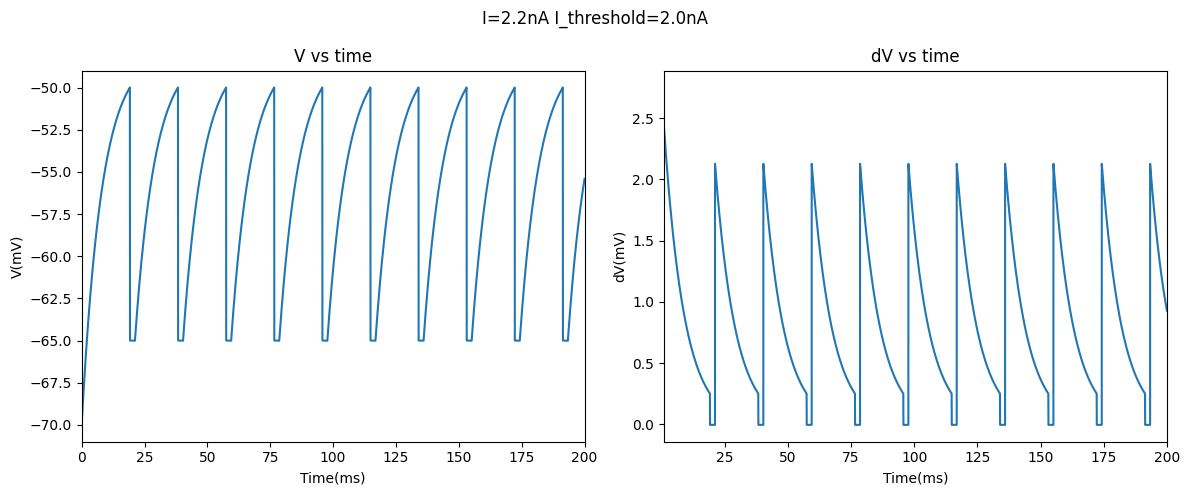

In [12]:
neuron.I = 2.2e-6
neuron.reset()
neuron.evolve()
fig, axes  = plt.subplots(ncols=2)
fig.set_tight_layout(True)
fig.set_figheight(5)
fig.set_figwidth(12)
axes.ravel()

axes[0].plot(neuron.t_span, neuron.v)
axes[0].set_xlabel('Time(ms)')
axes[0].set_xlim(0,200)
axes[0].set_ylabel('V(mV)')
axes[0].set_title('V vs time')

axes[1].plot(neuron.t_span, neuron.dv)
axes[1].set_xlabel('Time(ms)')
axes[1].set_xlim(1,200)
axes[1].set_ylabel('dV(mV)')
axes[1].set_title('dV vs time')
fig.suptitle('I='+str(neuron.I*1e6)+'nA'+' I_threshold='+str(((neuron.v_threshold - neuron.v_rest)/neuron.R)*1e6)+'nA')
fig.show()

###B. Minimum DC input current for a given threshold voltage

Text(0, 0.5, 'I_threshold(nA)')

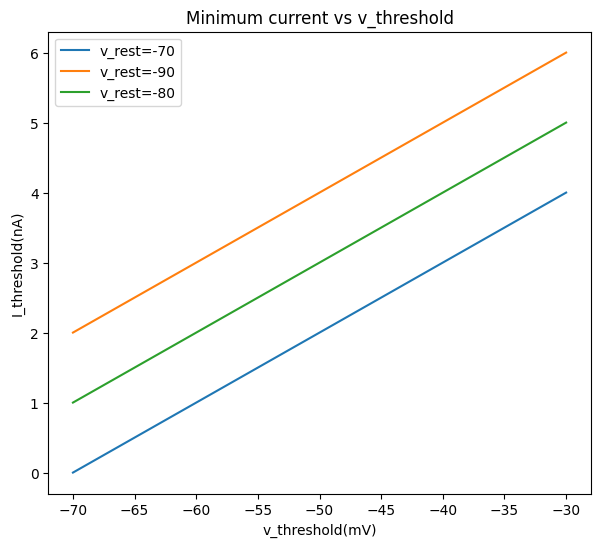

In [ ]:
v_rest = -70      #mV
v_threshold_range = np.linspace(-70, -30, 100) #mV
R = 10e6          #ohm
v_rest_range = [-70, -90, -80]
fig, axes = plt.subplots(1)
fig.set_figwidth(7)
fig.set_figheight(6)
for i, v_rest in enumerate(v_rest_range):
  I_threshold_range = []
  for v_threshold in v_threshold_range:
    I_threshold_range.append((v_threshold - v_rest)/R)  #mA
  axes.plot(v_threshold_range, np.array(I_threshold_range)*1e6, marker='')
axes.legend(['v_rest=-70','v_rest=-90','v_rest=-80'])
axes.set_title('Minimum current vs v_threshold')
axes.set_xlabel('v_threshold(mV)')
axes.set_ylabel('I_threshold(nA)')

###C. f-I (firing rate vs input current) curve by varying the constant input current.

In [13]:
v_threshold = -50
v_rest = -70
R=10e6
t = 1000
I_threshold = (v_threshold - v_rest)/R  #mA
neuron = SingleNeuron(v_init=-70,       #mV
                      v_rest=-70,       #mV
                      v_threshold=-50,  #mV
                      v_reset=-65,      #mV
                      v_change=0.2,     #mV
                      g=4,
                      R=10e6,           #ohm
                      I=2e-6,           #mA
                      t=1000,           #ms
                      dt=1e-2,          #ms
                      t_refractory=2,   #ms
                      tau=8,            #ms
                      poisson_rate_excitatory=0,   #mHz
                      poisson_rate_inhibitory=0,   #mHz
                      n_poisson_excitatory = 0,
                      n_poisson_inhibitory = 0)
neuron.reset()

TypeError: ignored

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

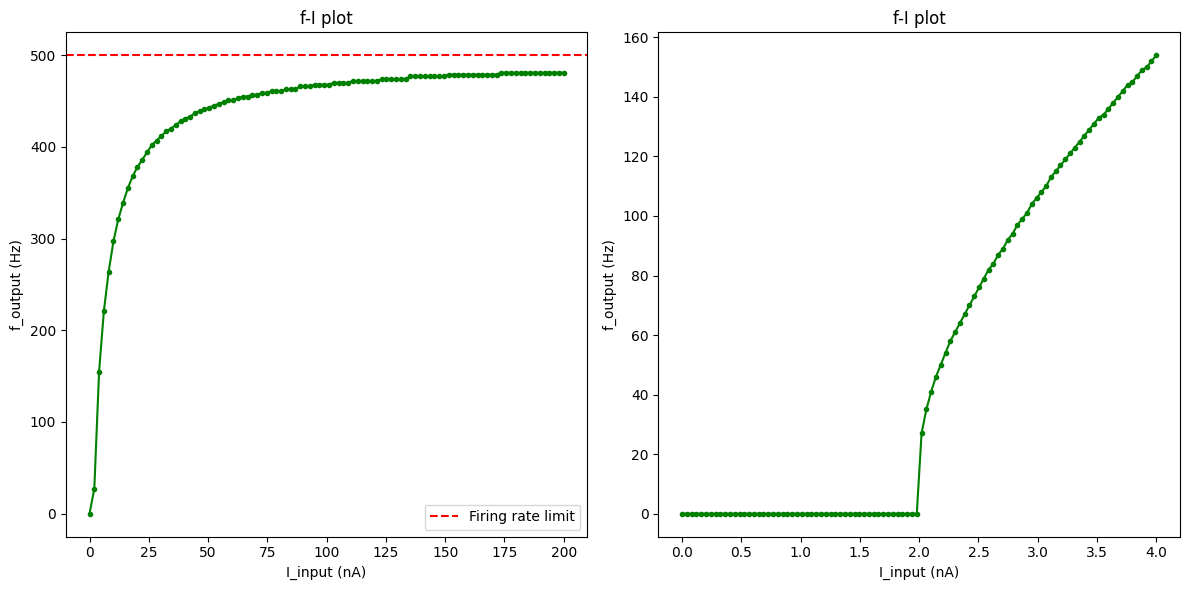

In [ ]:
I_range_range = [np.linspace(I_threshold - 2e-6, I_threshold*100, 100), np.linspace(I_threshold - 2e-6, I_threshold + 2e-6, 100)]

fig, axes = plt.subplots(ncols=2)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.set_tight_layout(True)
for i, I_range in enumerate(I_range_range):
  frequency_I = []
  for I in tqdm(I_range):
    neuron.I = I
    neuron.reset()    #reset previous output state variables before evolving
    neuron.evolve(tqdm_progress=False)
    spike_data = neuron.spike_data
    frequency = len(spike_data)/(neuron.t*1e-3)  #Hz
    frequency_I.append(frequency)
  if i == 0:
    axes[i].axhline(y=1/(neuron.t_refractory*1e-3), color='r', linestyle='--')
    axes[i].legend(['Firing rate limit'])
  axes[i].plot(I_range*1e6, frequency_I, color='g', marker='.')
  axes[i].set_xlabel('I_input (nA)')
  axes[i].set_ylabel('f_output (Hz)')
  axes[i].set_title('f-I plot')
fig.show()

### D. Drive the neuron by a volley of spikes, sampled from a poisson process with firing rate f_input, plot f vs f_input

In [14]:
v_rest = -70      #mV
v_threshold = -50 #mV
R = 10e6          #ohm
I_threshold = (v_threshold - v_rest)/R  #mA
t = 1000          #ms total simulation time

neuron = SingleNeuron(v_init=-70,       #mV
                      v_rest=-70,       #mV
                      v_threshold=-50,  #mV
                      v_reset=-65,      #mV
                      v_change=0.2,     #mV
                      g=4,
                      R=10e6,           #ohm
                      I=2e-6,           #mA
                      t=1000,           #ms
                      dt=1e-2,          #ms
                      t_refractory=2,   #ms
                      tau=8,            #ms
                      poisson_rate_excitatory=1,  #mHz
                      poisson_rate_inhibitory=0)  #mHz
neuron.reset()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

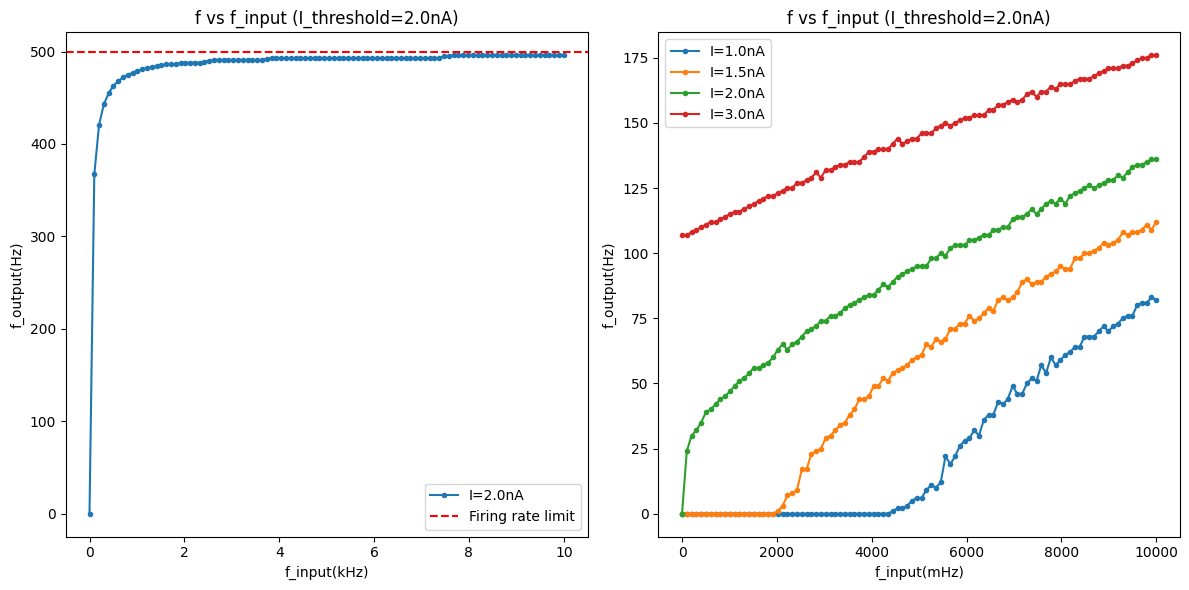

In [15]:
fig, axes = plt.subplots(ncols=2)
fig.set_tight_layout(True)
fig.set_figheight(6)
fig.set_figwidth(12)
excitatory_rate_ranges = [np.linspace(0, 1e7, 100), np.linspace(0, 10000, 100)]
for i, excitatory_rate_range in enumerate(excitatory_rate_ranges):
  legend = []
  if i == 0:
    I_range = [I_threshold]
  else:
    I_range = [I_threshold - 1e-6, I_threshold - 0.5e-6, I_threshold, I_threshold + 1e-6]
  for I in I_range:
    frequency_I = []
    neuron.I = I
    for poisson_rate_excitatory in tqdm(excitatory_rate_range):
      neuron.poisson_rate_excitatory = poisson_rate_excitatory
      neuron.reset()
      neuron.evolve(tqdm_progress=False)
      spike_data = neuron.spike_data
      frequency = len(spike_data)/(neuron.t*1e-3)  #mHz
      frequency_I.append(frequency)
    if i == 0:
      axes[i].plot(excitatory_rate_range/1e6, frequency_I, marker='.')
    else:
      axes[i].plot(excitatory_rate_range, frequency_I, marker='.')
      
    legend.append('I='+str(neuron.I*1e6)+'nA')
  
  axes[i].set_xlabel('f_input(mHz)')
  axes[i].set_ylabel('f_output(Hz)')
  axes[i].set_title('f vs f_input (I_threshold='+str(I_threshold*1e6)+'nA)')
  if i == 0:
    axes[i].axhline(y=1/(neuron.t_refractory*1e-3), linestyle='--', color='r')
    legend.append('Firing rate limit')
    axes[i].set_xlabel('f_input(kHz)')
  axes[i].legend(legend)
fig.show()

###E. Spike train of 100 randomly sampled neurons from a network of sparsely connected excitatory and inhibitory neurons

#### v_change > dv*dt

In [16]:
v_rest = -70                            #mV
v_threshold = -50                       #mV
R = 10e6                                #ohm
I_threshold = (v_threshold - v_rest)/R  #mA
n_total = 10000

sparse_network = NeuralNetwork(v_init = np.random.normal(loc=-60, scale=10, size=n_total), #mV
                               v_rest = -70,                #mV
                               v_threshold = -50,           #mV
                               v_reset = -65,               #mV
                               v_change = 0.1,              #mV
                               g = 4,
                               tau = 8,                     #ms
                               R = 10e6,                    #ohm
                               I = 2e-6,                    #mA
                               t = 200,                     #ms
                               dt = 1e-1,                   #ms
                               t_refractory = 2,            #ms
                               t_synaptic = 1.5,            #ms    
                               poisson_rate_excitatory = 0.5*1e6,#mHz
                               poisson_rate_inhibitory = 0, #mHz
                               n_total = n_total,
                               p_excitatory = 0.8,
                               p_connectivity = 0.1)
sparse_network.reset()

In [17]:
np.random.seed(42) #Don't panic replicability

In [18]:
warnings.filterwarnings("ignore")

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

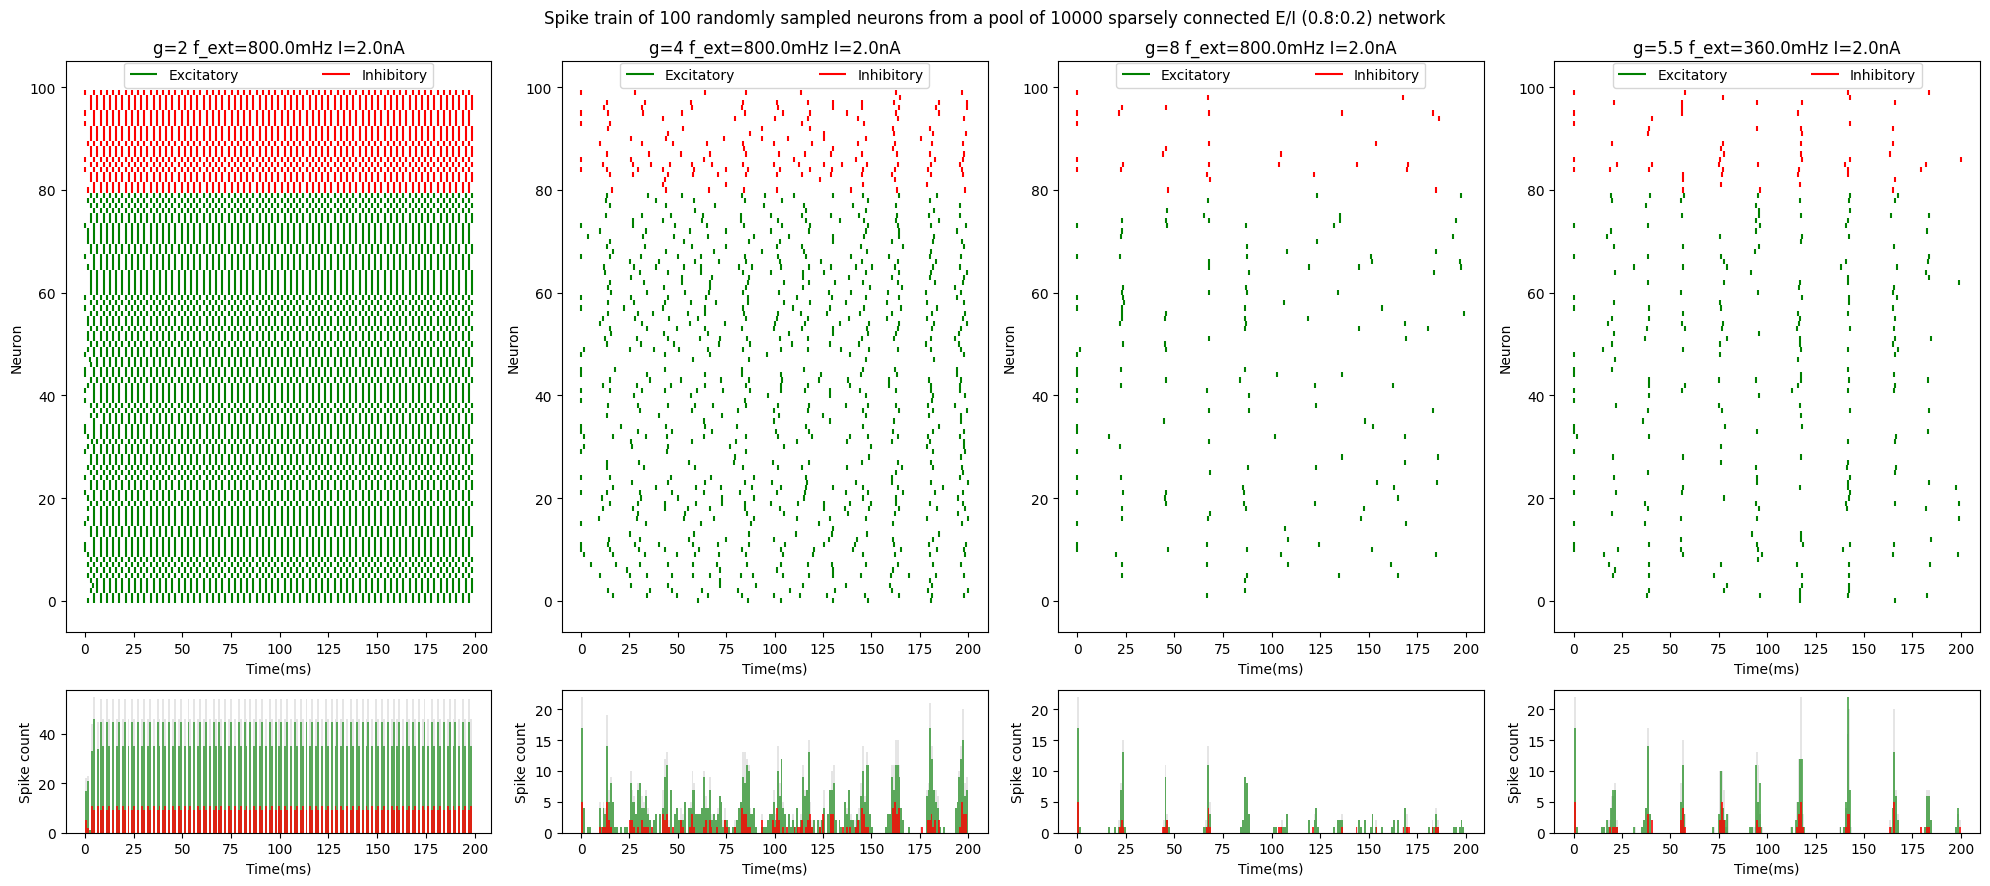

In [21]:
f_ext_range = np.array([4, 4, 4, 1.8])*200
g_range = [2, 4, 8, 5.5]

fig, axes  = plt.subplots(nrows=2, ncols=4, gridspec_kw={'height_ratios': [4, 1]})
fig.set_tight_layout(True)
fig.set_figheight(9)
fig.set_figwidth(20)

#grid location to mimic reference paper grid
# grid_location = [[[0,0],[1,0]],[[0,1],[1,1]],[[2,0],[3,0]],[[2,1],[3,1]]]

excitatory_neurons = np.random.choice(np.where(sparse_network.neuron_type == 1)[0], size=80, replace=False)
inhibitory_neurons = np.random.choice(np.where(sparse_network.neuron_type == -1)[0], size=20, replace=False)
# sample_neurons = np.random.choice(sparse_network.n_total, size=100, replace=False)
sample_neurons = np.concatenate((excitatory_neurons, inhibitory_neurons),axis=0)
colors = []
legend = []
excitatory_flag = 0
inhibitory_flag = 0
for neuron in sample_neurons:
  if sparse_network.neuron_type[neuron] == 1:
    colors.append('g')
    if not excitatory_flag:
      legend.append('Excitatory')
      excitatory_flag = 1
    elif not inhibitory_flag:
      legend.append('_nolegend_')
  else:
    colors.append('r')
    if not inhibitory_flag:
      legend.append('Inhibitory')
      inhibitory_flag = 1
    elif not excitatory_flag:
      legend.append('_nolegend_')

for i, (rate, g) in enumerate(zip(f_ext_range, g_range)):
  sparse_network.poisson_rate_excitatory = rate
  sparse_network.poisson_rate_inhibitory = 0
  sparse_network.g = g
  sparse_network.reset()
  sparse_network.evolve()

  _ = axes[0][i].eventplot(sparse_network.spike_data[sample_neurons], linelengths=1, colors=colors)
  axes[0][i].set_title('g='+str(g)+' f_ext='+str(rate)+'mHz'+' I='+str(sparse_network.I*1e6)+'nA')
  axes[0][i].set_xlabel('Time(ms)')
  axes[0][i].set_ylabel('Neuron')
  _ = axes[0][i].legend(legend, bbox_to_anchor=(0., 1.0, 1., .10), ncols=2, mode='expand', borderaxespad=4.2)

  all_spikes = []
  for neuron in sample_neurons:
    all_spikes.extend(sparse_network.spike_data[neuron])

  excitatory_spikes = []
  inhibitory_spikes = []
  for neuron in sample_neurons:
    if sparse_network.neuron_type[neuron] == 1:
      excitatory_spikes.extend(sparse_network.spike_data[neuron])
    else:
      inhibitory_spikes.extend(sparse_network.spike_data[neuron])

  _ = axes[1][i].hist(all_spikes, bins=int(len(sparse_network.t_span)/10), color='k', alpha=0.1)
  _ = axes[1][i].hist(excitatory_spikes, bins=int(len(sparse_network.t_span)/10), color='g', alpha=0.6)
  _ = axes[1][i].hist(inhibitory_spikes, bins=int(len(sparse_network.t_span)/10), color='r', alpha=0.8)
  axes[1][i].set_title('')
  axes[1][i].set_xlabel('Time(ms)')
  axes[1][i].set_ylabel('Spike count')

fig.suptitle('Spike train of 100 randomly sampled neurons from a pool of 10000 sparsely connected E/I (0.8:0.2) network')
fig.show()

#### v_change < dv*dt

In [22]:
v_rest = -70                            #mV
v_threshold = -50                       #mV
R = 10e6                                #ohm
I_threshold = (v_threshold - v_rest)/R  #mA
n_total = 10000

sparse_network = NeuralNetwork(v_init = np.random.normal(loc=-65, scale=7, size=n_total), #mV
                               v_rest = -70,                #mV
                               v_threshold = -50,           #mV
                               v_reset = -65,               #mV
                               v_change = 0.1,              #mV
                               g = 4,
                               tau = 8,                     #ms
                               R = 10e6,                    #ohm
                               I = 2e-6,                    #mA
                               t = 200,                     #ms
                               dt = 1e-1,                   #ms
                               t_refractory = 2,            #ms
                               t_synaptic = 1.5,            #ms    
                               poisson_rate_excitatory = 0.5*1e6, #mHz
                               poisson_rate_inhibitory = 0,       #mHz
                               n_total = n_total,
                               p_excitatory = 0.8,
                               p_connectivity = 0.1)
sparse_network.reset()

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

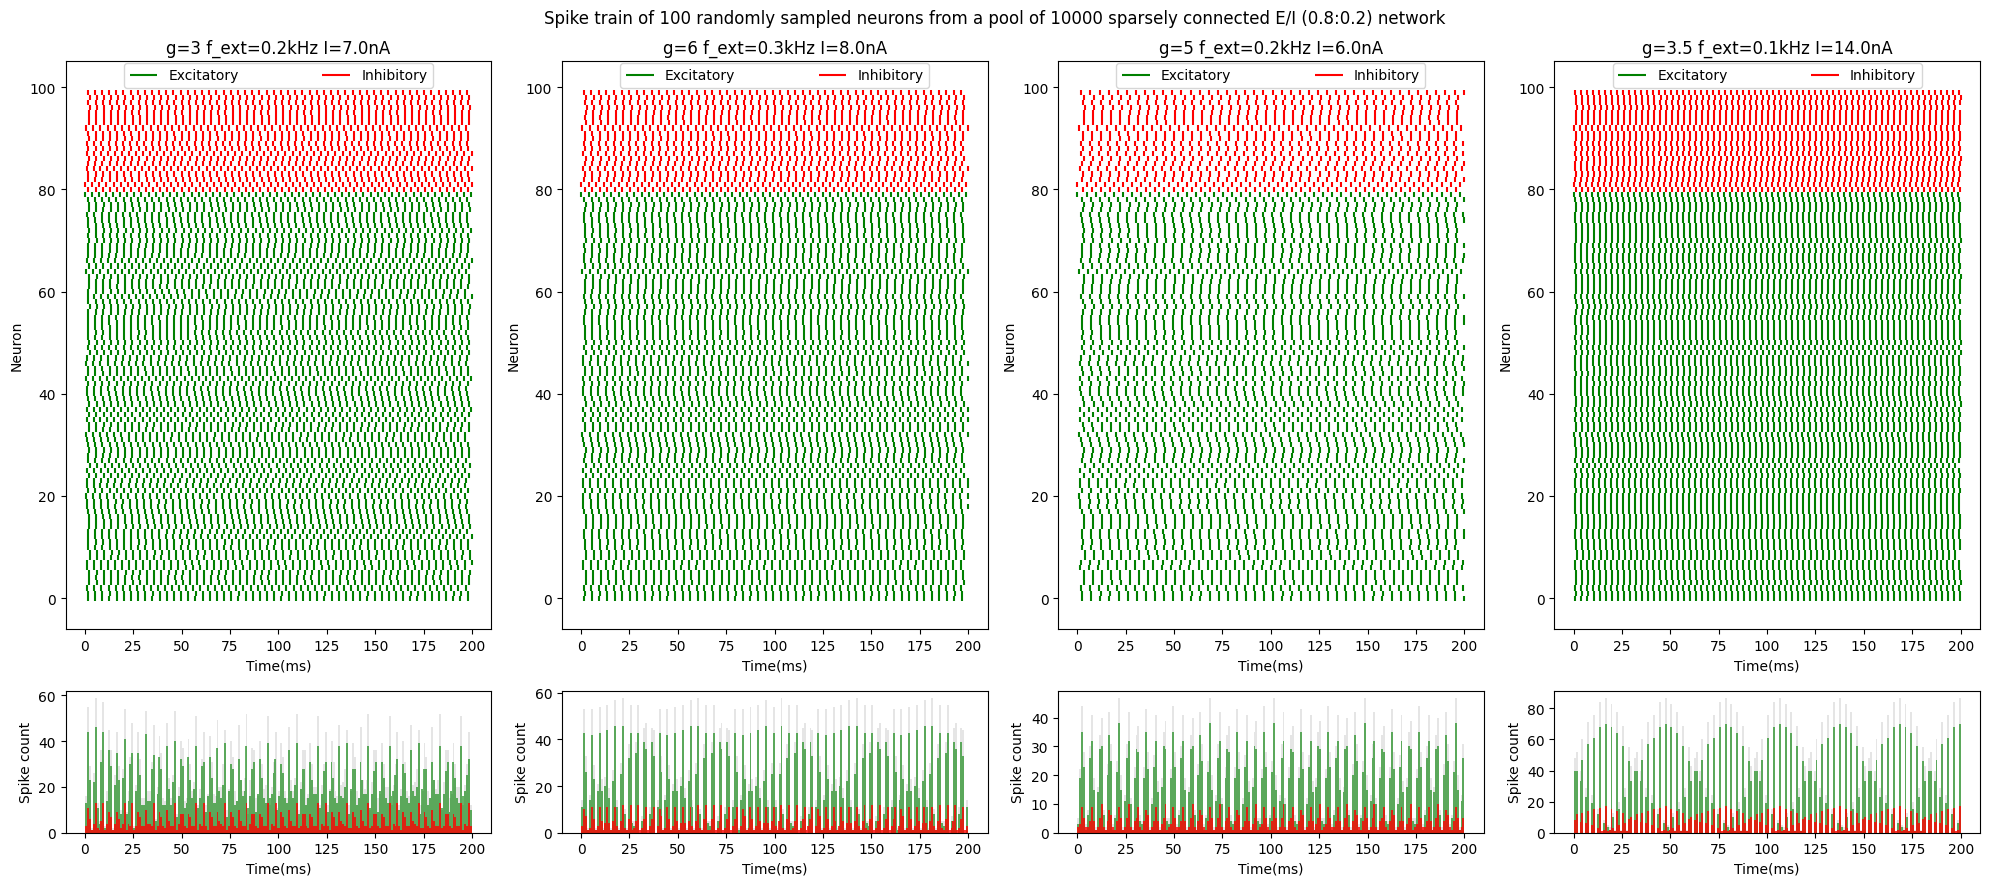

In [23]:
np.random.seed(42) #Don't panic replicability
warnings.filterwarnings("ignore")
f_ext_range = np.array([2,3,2,1])*1e5 #mHz
g_range = [3,6,5,3.5]
I_range = np.array([3.5,4,3,7])*2e-6  #nA

fig, axes  = plt.subplots(nrows=2, ncols=4, gridspec_kw={'height_ratios': [4, 1]})
fig.set_tight_layout(True)
fig.set_figheight(9)
fig.set_figwidth(20)

#grid location to mimic reference paper grid
# grid_location = [[[0,0],[1,0]],[[0,1],[1,1]],[[2,0],[3,0]],[[2,1],[3,1]]]

excitatory_neurons = np.random.choice(np.where(sparse_network.neuron_type == 1)[0], size=80, replace=False)
inhibitory_neurons = np.random.choice(np.where(sparse_network.neuron_type == -1)[0], size=20, replace=False)
# sample_neurons = np.random.choice(sparse_network.n_total, size=100, replace=False)
sample_neurons = np.concatenate((excitatory_neurons, inhibitory_neurons),axis=0)
colors = []
legend = []
excitatory_flag = 0
inhibitory_flag = 0
for neuron in sample_neurons:
  if sparse_network.neuron_type[neuron] == 1:
    colors.append('g')
    if not excitatory_flag:
      legend.append('Excitatory')
      excitatory_flag = 1
    elif not inhibitory_flag:
      legend.append('_nolegend_')
  else:
    colors.append('r')
    if not inhibitory_flag:
      legend.append('Inhibitory')
      inhibitory_flag = 1
    elif not excitatory_flag:
      legend.append('_nolegend_')

for i, (rate, g) in enumerate(zip(f_ext_range, g_range)):
  sparse_network.poisson_rate_excitatory = rate
  sparse_network.v_change = sparse_network.v_change * sparse_network.dt
  sparse_network.I = I_range[i]
  sparse_network.g = g
  sparse_network.reset()
  sparse_network.evolve()

  _ = axes[0][i].eventplot(sparse_network.spike_data[sample_neurons], linelengths=1, colors=colors)
  axes[0][i].set_title('g='+str(g)+' f_ext='+str(rate/1e6)+'kHz'+' I='+str(sparse_network.I*1e6)+'nA')
  axes[0][i].set_xlabel('Time(ms)')
  axes[0][i].set_ylabel('Neuron')
  _ = axes[0][i].legend(legend, bbox_to_anchor=(0., 1.0, 1., .10), ncols=2, mode='expand', borderaxespad=4.2)

  all_spikes = []
  for neuron in sample_neurons:
    all_spikes.extend(sparse_network.spike_data[neuron])

  excitatory_spikes = []
  inhibitory_spikes = []
  for neuron in sample_neurons:
    if sparse_network.neuron_type[neuron] == 1:
      excitatory_spikes.extend(sparse_network.spike_data[neuron])
    else:
      inhibitory_spikes.extend(sparse_network.spike_data[neuron])

  _ = axes[1][i].hist(all_spikes, bins=int(len(sparse_network.t_span)/10), color='k', alpha=0.1)
  _ = axes[1][i].hist(excitatory_spikes, bins=int(len(sparse_network.t_span)/10), color='g', alpha=0.6)
  _ = axes[1][i].hist(inhibitory_spikes, bins=int(len(sparse_network.t_span)/10), color='r', alpha=0.8)
  axes[1][i].set_title('')
  axes[1][i].set_xlabel('Time(ms)')
  axes[1][i].set_ylabel('Spike count')

fig.suptitle('Spike train of 100 randomly sampled neurons from a pool of 10000 sparsely connected E/I (0.8:0.2) network')
fig.show()

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

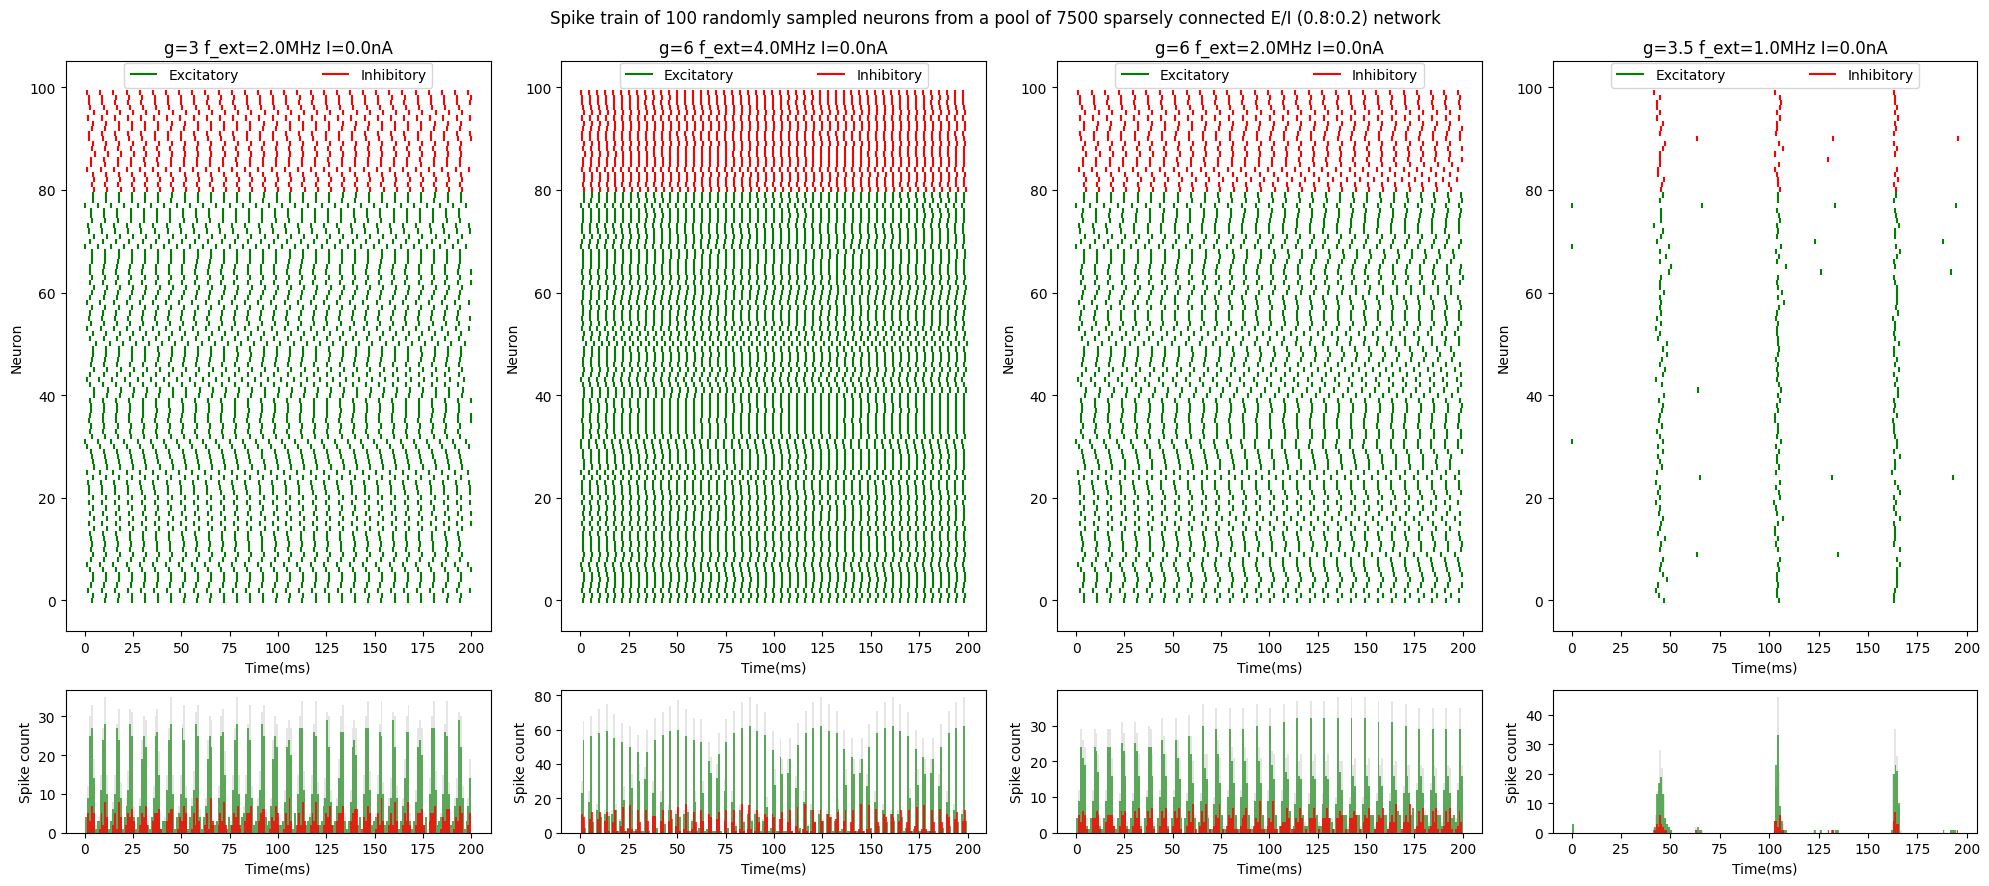

In [ ]:
f_ext_range = np.array([2,4,2,1])*1e6 #mHz
g_range = [3,6,5,3.5]

fig, axes  = plt.subplots(nrows=2, ncols=4, gridspec_kw={'height_ratios': [4, 1]})
fig.set_tight_layout(True)
fig.set_figheight(9)
fig.set_figwidth(20)

#grid location to mimic reference paper grid
# grid_location = [[[0,0],[1,0]],[[0,1],[1,1]],[[2,0],[3,0]],[[2,1],[3,1]]]

excitatory_neurons = np.random.choice(np.where(sparse_network.neuron_type == 1)[0], size=80, replace=False)
inhibitory_neurons = np.random.choice(np.where(sparse_network.neuron_type == -1)[0], size=20, replace=False)
# sample_neurons = np.random.choice(sparse_network.n_total, size=100, replace=False)
sample_neurons = np.concatenate((excitatory_neurons, inhibitory_neurons),axis=0)
colors = []
legend = []
excitatory_flag = 0
inhibitory_flag = 0
for neuron in sample_neurons:
  if sparse_network.neuron_type[neuron] == 1:
    colors.append('g')
    if not excitatory_flag:
      legend.append('Excitatory')
      excitatory_flag = 1
    elif not inhibitory_flag:
      legend.append('_nolegend_')
  else:
    colors.append('r')
    if not inhibitory_flag:
      legend.append('Inhibitory')
      inhibitory_flag = 1
    elif not excitatory_flag:
      legend.append('_nolegend_')

for i, (rate, g) in enumerate(zip(f_ext_range, g_range)):
  sparse_network.poisson_rate_excitatory = rate
  sparse_network.g = g
  sparse_network.reset()
  sparse_network.evolve()

  _ = axes[0][i].eventplot(sparse_network.spike_data[sample_neurons], linelengths=1, colors=colors)
  axes[0][i].set_title('g='+str(g)+' f_ext='+str(rate/1e6)+'kHz'+' I='+str(sparse_network.I*1e6)+'nA')
  axes[0][i].set_xlabel('Time(ms)')
  axes[0][i].set_ylabel('Neuron')
  _ = axes[0][i].legend(legend, bbox_to_anchor=(0., 1.0, 1., .10), ncols=2, mode='expand', borderaxespad=4.2)

  all_spikes = []
  for neuron in sample_neurons:
    all_spikes.extend(sparse_network.spike_data[neuron])

  excitatory_spikes = []
  inhibitory_spikes = []
  for neuron in sample_neurons:
    if sparse_network.neuron_type[neuron] == 1:
      excitatory_spikes.extend(sparse_network.spike_data[neuron])
    else:
      inhibitory_spikes.extend(sparse_network.spike_data[neuron])

  _ = axes[1][i].hist(all_spikes, bins=int(len(sparse_network.t_span)/10), color='k', alpha=0.1)
  _ = axes[1][i].hist(excitatory_spikes, bins=int(len(sparse_network.t_span)/10), color='g', alpha=0.6)
  _ = axes[1][i].hist(inhibitory_spikes, bins=int(len(sparse_network.t_span)/10), color='r', alpha=0.8)
  axes[1][i].set_title('')
  axes[1][i].set_xlabel('Time(ms)')
  axes[1][i].set_ylabel('Spike count')

fig.suptitle('Spike train of 100 randomly sampled neurons from a pool of 7500 sparsely connected E/I (0.8:0.2) network')
fig.show()

####Animation

In [ ]:
v_rest = -70                            #mV
v_threshold = -50                       #mV
R = 10e6                                #ohm
I_threshold = (v_threshold - v_rest)/R  #mA
n_total = 10000

sparse_network = NeuralNetwork(v_init = np.random.normal(loc=-60, scale=6, size=n_total), #mV
                               v_rest = -70,                #mV
                               v_threshold = -50,           #mV
                               v_reset = -65,               #mV
                               v_change = 0.01,              #mV
                               g = 4,
                               tau = 8,                     #ms
                               R = 10e6,                    #ohm
                               I = 2.2e-6,                    #mA
                               t = 2000,                     #ms
                               dt = 1e-1,                   #ms
                               t_refractory = 2,            #ms
                               t_synaptic = 1.5,            #ms    
                               poisson_rate_excitatory = 0.5*1e6, #mHz
                               poisson_rate_inhibitory = 0,       #mHz
                               n_total = n_total,
                               p_excitatory = 0.8,
                               p_connectivity = 0.1)
sparse_network.reset()

In [ ]:
excitatory_neurons = np.random.choice(np.where(sparse_network.neuron_type == 1)[0], size=80, replace=False)
inhibitory_neurons = np.random.choice(np.where(sparse_network.neuron_type == -1)[0], size=20, replace=False)
# sample_neurons = np.random.choice(sparse_network.n_total, size=100, replace=False)
sample_neurons = np.concatenate((excitatory_neurons, inhibitory_neurons),axis=0)
colors = []
legend = []
excitatory_flag = 0
inhibitory_flag = 0
for neuron in sample_neurons:
  if sparse_network.neuron_type[neuron] == 1:
    colors.append('g')
    if not excitatory_flag:
      legend.append('Excitatory')
      excitatory_flag = 1
    elif not inhibitory_flag:
      legend.append('_nolegend_')
  else:
    colors.append('r')
    if not inhibitory_flag:
      legend.append('Inhibitory')
      inhibitory_flag = 1
    elif not excitatory_flag:
      legend.append('_nolegend_')

sparse_network.poisson_rate_excitatory = 400
sparse_network.poisson_rate_inhibitory = 0
sparse_network.g = 4
sparse_network.reset()
sparse_network.evolve()

  0%|          | 0/19999 [00:00<?, ?it/s]

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
frame_rate = 60 #s
animation_duration = 15  #s
number_of_frames = frame_rate * animation_duration


t_frame = np.linspace(0, sparse_network.t, int(number_of_frames)).astype(int)

fig, axes  = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [4, 1]})
fig.set_tight_layout(True)
fig.set_figheight(9)
fig.set_figwidth(6)


for i in tqdm(range(len(t_frame))):

  spike_data = []
  for neuron in sample_neurons:
    spike_data.append([])
    for data in sparse_network.spike_data[neuron]:
      if data >= t_frame[i] and data < t_frame[i]+200:
        spike_data[-1].append(data)
  
  _ = axes[0].eventplot(spike_data, linelengths=1, colors=colors)
  axes[0].set_title('g='+str(sparse_network.g)+' f_ext='+str(sparse_network.poisson_rate_excitatory)+'Hz'+' I='+str(sparse_network.I*1e6)+'nA')
  axes[0].set_xlim(left=t_frame[i], right=t_frame[i]+200)
  axes[0].set_xticks(ticks=[t_frame[i],t_frame[i]+100,t_frame[i]+200], labels=['+0','+100','+200'])
  axes[0].set_xlabel('Time(ms)')
  axes[0].set_ylabel('Neuron')
  _ = axes[0].legend(legend, bbox_to_anchor=(0., 1.0, 1., .10), ncols=2, mode='expand', borderaxespad=4.2)

  all_spikes = []
  excitatory_spikes = []
  inhibitory_spikes = []
  for j, neuron in enumerate(sample_neurons):
    all_spikes.extend(spike_data[j])
    if sparse_network.neuron_type[neuron] == 1:
      excitatory_spikes.extend(spike_data[j])
    else:
      inhibitory_spikes.extend(spike_data[j])

  _ = axes[1].hist(np.array(all_spikes).astype(np.int32), bins=100, color='k', alpha=0.1)
  _ = axes[1].hist(np.array(excitatory_spikes).astype(np.int32), bins=100, color='g', alpha=0.6)
  _ = axes[1].hist(np.array(inhibitory_spikes).astype(np.int32), bins=100, color='r', alpha=0.8)
  axes[1].set_title('')
  axes[1].set_xlim(left=t_frame[i], right=t_frame[i]+200)
  axes[1].set_ylim(bottom=0, top=30)
  axes[1].set_xticks(ticks=[t_frame[i],t_frame[i]+100,t_frame[i]+200], labels=['+0','+100','+200'])
  axes[1].set_xlabel('Time(ms)')
  axes[1].set_ylabel('Spike count')

  fig.suptitle('Spike train of sparse_network (timestamp=%.0f)'%t_frame[i])
  file_name = (3 - len(str(i)))*'0' + str(i) + '.png'
  fig.savefig(file_name)
  axes[0].cla()
  axes[1].cla()
del fig
plt.close('all')

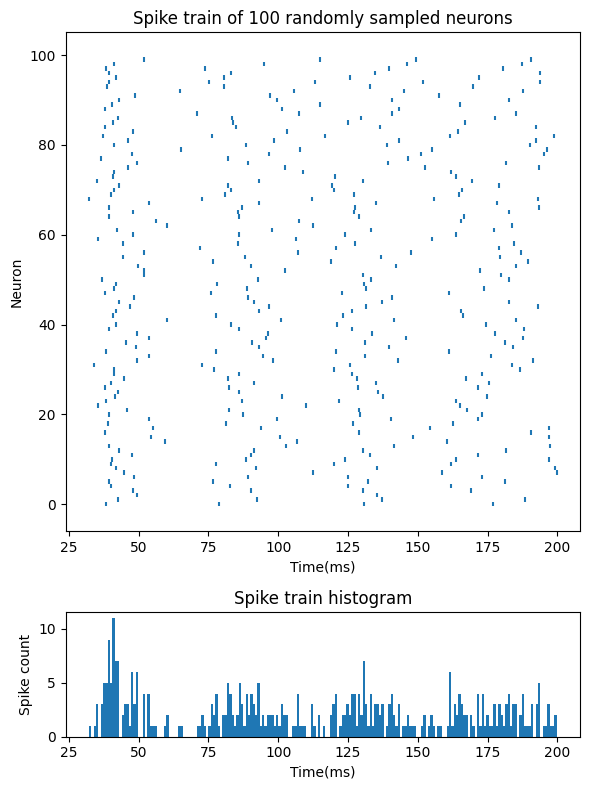

In [ ]:
sample_neurons = np.random.choice(sparse_network.N_total, size=100, replace=False)
fig, axes  = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [4, 1]})
fig.set_tight_layout(True)
fig.set_figheight(8)
fig.set_figwidth(6)
axes.ravel()

_ = axes[0].eventplot(sparse_network.spike_data[sample_neurons], linelengths=1)
axes[0].set_title('Spike train of 100 randomly sampled neurons')
axes[0].set_xlabel('Time(ms)')
axes[0].set_ylabel('Neuron')

all_spikes = np.array([])
for i, data in enumerate(sparse_network.spike_data[sample_neurons]):
  all_spikes = np.concatenate([all_spikes, data])

_ = axes[1].hist(all_spikes, bins=int(len(sparse_network.t_span)/10))
axes[1].set_title('Spike train histogram')
axes[1].set_xlabel('Time(ms)')
axes[1].set_ylabel('Spike count')
fig.show()

#ODE solver

In [ ]:
def evolve_single_neuron(t, y, dV, R, I, v_change, tau, poisson_spike, active_state, v_rest, v_threshold, t_ref_timer, t_refractory, t_last, t_end, v_inp_rate):
  v = y[0]
  # print(type(t_last), t_last)
  dt = t - t_last[0]
  v_imp = v_change * poisson_spike[0]
  if t_ref_timer[0] >= t_refractory or t_ref_timer[0] < 0:
    active_state[0] = 1
    t_ref_timer[0] = -1
  elif t_ref_timer[0] >= 0 and t_ref_timer[0] < t_refractory:
    t_ref_timer[0] += dt
  if active_state[0]:
    if v >= v_threshold:
      active_state[0] = 0
      t_ref_timer[0] = 0
  v_imp = v_change * np.random.poisson(v_input_rate, 1)[0]
  dv = (-1*(v - v_rest) + active_state[0]*(R*I + v_imp))/tau
  # dV.append(dv)
  t_last[0] = t
  step_counter[0] += 1
  return dv

def action_potential_event(t, y, dV, R, I, v_change, tau, poisson_spike, active_state, v_rest, v_threshold, t_ref_timer, t_refractory, t_last, t_end, v_input_rate):
  v = y[0]
  return v-v_threshold

def end_event(t, y, dV, R, I, v_change, tau, poisson_spike, active_state, v_rest, v_threshold, t_ref_timer, t_refractory, t_last, t_end, v_input_rate):
  return t-t_end

end_event.terminal = True
action_potential_event.terminal = True
action_potential_event.direction = 1

In [ ]:
t = 1000  #ms
dt = 1e-2 #ms
t_span = np.linspace(0,t,int(t/dt))
dV = []
v_init = -70  #mV
dv_init = 0
v_reset = -65 #mV
v_rest = -70  #mV
v_threshold = -50 #mV
R = 10e6 #ohm
tau = 8 #ms
v_change = 0.2  #mV
active_state = [int(v_init < v_threshold)]  #initialize with neuron in active state
if v_init < v_threshold:
  t_ref_timer = [-1]
else:
  t_ref_timer = [0]
t_refractory = 2  #ms
step_counter = [0]

I_threshold = (v_threshold - v_rest)/R  #mA
I = 2e-6 #mA
v_input_rate = 1

poisson_spike = np.random.poisson(v_input_rate, t_span.shape[0])

t_start = t_span[0]
t_end = t_span[-1]
t_last = [t_start]

v = np.array([])
t = np.array([])
dv_all = np.array([])
while t_start < t_end:
  sol = scipy.integrate.solve_ivp(evolve_single_neuron, t_span=[t_start, t_end], y0=[v_init, dv_init], t_eval=t_span,
                        args=(dV, R, I, v_change, tau, poisson_spike, active_state, v_rest, v_threshold, t_ref_timer, t_refractory, t_last, t_end, v_input_rate),
                        events = [action_potential_event, end_event],
                        max_step = dt)
  v_init = sol.y[0][-1]
  t_start = sol.t[-1]
  t_span = np.linspace(t_start, t_end, int((t_end-t_start)/dt))
  if t_start < t_end:
    # print(v_init, t_start)
    if v_init >= v_threshold:
      v_init = v_reset
  v = np.concatenate([v,sol.y[0]], axis=0)
  # dv_all = np.concatenate([dv, sol.y[1]], axis=0)
  t = np.concatenate([t,sol.t[:]], axis=0)

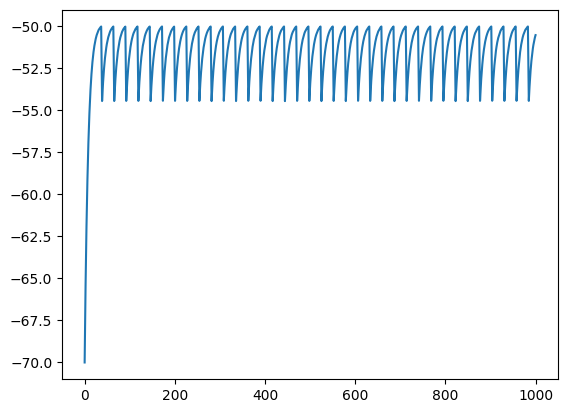

In [ ]:
plt.plot(t,v)